# Contrastive Explanations Method (CEM) applied to MNIST

The Contrastive Explanation Method (CEM) can generate black box model explanations in terms of pertinent positives (PP) and pertinent negatives (PN). For PP, it finds what should be minimally and sufficiently present (e.g. important pixels in an image) to justify its classification. PN on the other hand identify what should be minimally and necessarily absent from the explained instance in order to maintain the original prediction.

The original paper where the algorithm is based on can be found on [arXiv](https://arxiv.org/pdf/1802.07623.pdf).

In [59]:
import keras
from keras import backend as K
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from keras.models import Model, load_model
from keras.utils import to_categorical
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from alibi.explainers import CEM

## Load and prepare MNIST data

x_train shape: (60000, 28, 28) y_train shape: (60000,)


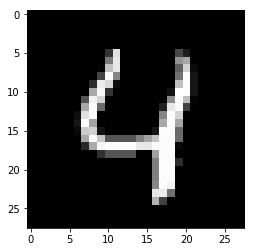

In [60]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)
plt.gray()
plt.imshow(x_test[4])

Prepare data: scale, reshape and categorize

In [61]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)


In [62]:
xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin

## Define and train CNN model

In [63]:
def cnn_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x_in)
    x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    x = Flatten()(x)
    x = Dense(200, activation='relu')(x)
    x = Dense(200, activation='relu')(x)
    x_out = Dense(10, activation='softmax')(x)
    
    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return cnn

In [64]:
cnn = cnn_model()
cnn.summary()
cnn.fit(x_train, y_train, batch_size=64, epochs=5, verbose=0)
cnn.save('mnist_cnn.h5')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        3692

Evaluate the model on test set

In [65]:
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

Test accuracy:  0.9930999875068665


## Define and train auto-encoder

In [66]:
def ae_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x_in)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)

    autoencoder = Model(x_in, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

In [67]:
ae = ae_model()
ae.summary()
ae.fit(x_train, x_train, batch_size=128, epochs=10, validation_data=(x_test, x_test), verbose=0)
ae.save('mnist_ae.h5')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 1)         145       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 16)        0   

Compare original with decoded images

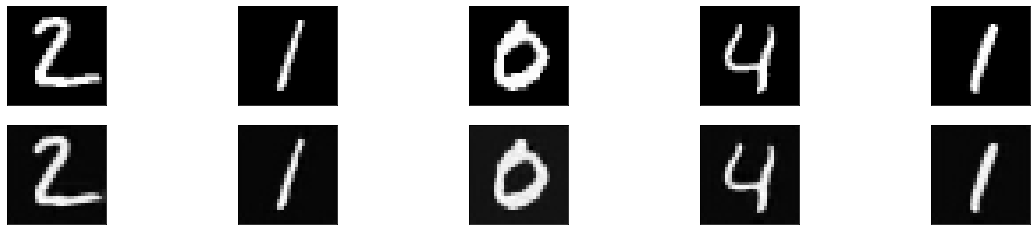

In [68]:
decoded_imgs = ae.predict(x_test)
n = 5
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Generate contrastive explanation with pertinent negative

Explained instance:

In [69]:
idx = 8
X = x_test[idx].reshape((1,) + x_test[idx].shape)

CEM parameters:

In [70]:
mode = 'PN'  # 'PN' (pertinent negative) or 'PP' (pertinent positive)
shape = (1,) + x_train.shape[1:]  # instance shape
kappa = 0.  # minimum difference needed between the prediction probability for the perturbed instance on the
            # class predicted by the original instance and the max probability on the other classes 
            # in order for the first loss term to be minimized
beta = .1  # weight of the L1 loss term
gamma = 100  # weight of the optional auto-encoder loss term
c_init = 1.  # initial weight c of the loss term encouraging to predict a different class (PN) or 
              # the same class (PP) for the perturbed instance compared to the original instance to be explained
c_steps = 10  # nb of updates for c
max_iterations = 1000  # nb of iterations per value of c
feature_range = (x_train.min(),x_train.max())  # feature range for the perturbed instance
clip = (-1000.,1000.)  # gradient clipping
lr = 1e-2  # initial learning rate
no_info_val = -1. # a value, float or feature-wise, which can be seen as containing no info to make a prediction
                  # perturbations towards this value means removing features, and away means adding features
                  # for our MNIST images, the background (-0.5) is the least informative, 
                  # so positive/negative perturbations imply adding/removing features

Generate pertinent negative:

In [71]:
# initialize TensorFlow session before model definition
sess = tf.Session()
K.set_session(sess)
sess.run(tf.global_variables_initializer())

# define models
cnn = load_model('mnist_cnn.h5')
ae = load_model('mnist_ae.h5')

# initialize CEM explainer and explain instance
cem = CEM(cnn, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range, 
          gamma=gamma, ae_model=ae, max_iterations=max_iterations, 
          c_init=c_init, c_steps=c_steps, learning_rate_init=lr, clip=clip, no_info_val=no_info_val, sess=sess)
explanation = cem.explain(X, verbose=False)

sess.close()
K.clear_session()

Original instance and prediction:

Original instance prediction: 5


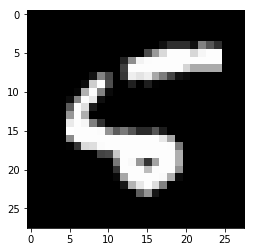

In [72]:
print('Original instance prediction: {}'.format(explanation['X_pred']))
plt.imshow(explanation['X'].reshape(28, 28))

Pertinent negative:

Pertinent negative prediction: 8


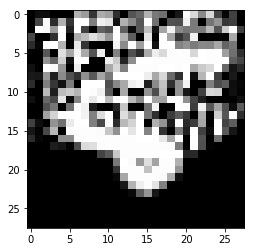

In [73]:
print('Pertinent negative prediction: {}'.format(explanation[mode + '_pred']))
plt.imshow(explanation[mode].reshape(28, 28))

## Generate pertinent positive

In [74]:
mode = 'PP'

In [75]:
# initialize TensorFlow session before model definition
sess = tf.Session()
K.set_session(sess)
sess.run(tf.global_variables_initializer())

# define models
cnn = load_model('mnist_cnn.h5')
ae = load_model('mnist_ae.h5')

# initialize CEM explainer and explain instance
cem = CEM(cnn, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range, 
          gamma=gamma, ae_model=ae, max_iterations=max_iterations, 
          c_init=c_init, c_steps=c_steps, learning_rate_init=lr, clip=clip, no_info_val=no_info_val, sess=sess)
explanation = cem.explain(X, verbose=False)

sess.close()
K.clear_session()

Pertinent positive:

Pertinent positive prediction: 5


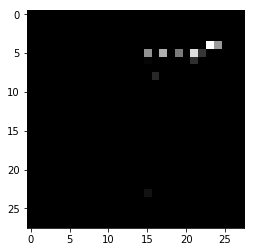

In [76]:
print('Pertinent positive prediction: {}'.format(explanation[mode + '_pred']))
plt.imshow(explanation[mode].reshape(28, 28))

Clean up:

In [52]:
os.remove('mnist_cnn.h5')
os.remove('mnist_ae.h5')